In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
importlib.reload(LSTM)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x


# kernel = Matern()#length_scale = [1,1],length_scale_bounds="fixed")
# kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point



    N  T  MSE  STD
0  19  3  0.0  0.0
1  22  6  0.0  0.0
2  55  1  0.0  0.0
3  27  6  0.0  0.0
4  17  1  0.0  0.0
{'N_Min': 5, 'proc': 3, 'epochs': 100, 'N_Max': 100, 'Y': 'fch4', 'reps': 3, 'T_Max': 10, 'Searches': 2}


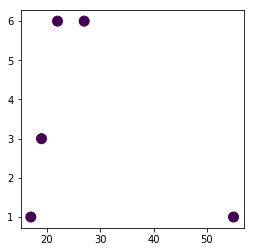

In [2]:
FillVar = 'fch4'
Runs,params = LSTM.Params('Test',FillVar,MP=True)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

In [3]:
def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))


AllVars = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','Rain','Water Table']

FullModel = ['Wind Spd','air pressure','Water Table','PPFD','Ts 2.5 cm']

Time = time.time()
Path = 'FilteredData2018-04-04.csv'

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time.copy()#*1.0
    X = RST.X_time.copy()#*1.0
    X_fill = RST.X_ftime.copy()
    MSE = []
    STD = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    FillVarName = 'Fch4'
    RST.Fill(Y_fill,FillVarName)
    if plot == True:
        plt.figure(figsize=(5,5))
        plt.plot(RST.Master['Fch4'],color='red')
#         plt.plot(RST.Master['fch4'],color='grey')
        plt.plot(RST.Master['TempFill'],color='blue',alpha=.5)  # This works
        
        yl = plt.ylim()
#         plt.xlim(yl[0],yl[1])
        plt.grid()
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i))

print(Runs)

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehed Run  0
Finisehed Run  1
Finisehed Run  2
Finisehed Run  3
Finisehed Run  4
    N  T       MSE       STD
0  19  3  0.636203  0.048880
1  22  6  0.768829  0.084966
2  55  1  0.637128  0.081770
3  27  6  0.770221  0.083389
4  17  1  0.653799  0.084727


In [ ]:

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
        if N < params['N_Min'] or N > params['N_Max']:
            N -= int(o*np.cos(o*np.pi))
        if o > 5:
            T += 1
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    params['T'] = T
    params['N'] = N
    
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)
Optimum = Runs[Runs['MSE'] == Runs['MSE'].min()]
print('Optimum:')
print(Optimum)

[ 16.48874563   3.84976088]
16 4
[ 19.58429205   0.64467333]
20 1
        MSE   N       STD  T
0  0.815269  16  0.067573  4
1  0.653799  17  0.084727  1
2  0.636203  19  0.048880  3
3  0.669973  20  0.077086  1
4  0.768829  22  0.084966  6
5  0.770221  27  0.083389  6
6  0.637128  55  0.081770  1
Optimum:
        MSE   N      STD  T
2  0.636203  19  0.04888  3


In [ ]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if set(factor).issubset(set(c)):
#             if factor in c:
                Models.append(c)
    return(Models)
# params['T']=Optimum['T'].values[0]
# params['N']=Optimum['N'].values[0]

params['T']=Optimum['T']=36#.values[0]
params['N']=Optimum['N']=6#.values[0]


Results = RunReps(FullModel,params,pool,FullReturn=True)
FullScore = Results[0]
Data = Results[1]


BestMSE = []
BestSTD = []
idx = []
BestModels = []

print(FullModel)

for i in range(1,len(FullModel)+1):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     for model in Models:
    Score = []
    STD = []
    Model_Names = []
    
    for model in Models:
        print()
        print(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        Score.append(MSE.mean())
        STD.append(MSE.std())
        Data['Model: '+'+'.join(model)] = Results[1]
        Model_Names.append('Model: '+'+'.join(model))
        
    Score = np.asanyarray(Score)
    STD = np.asanyarray(STD)
    print(Model_Names)
    print(np.where(Score == Score.min())[0][0])
    Best = Models[np.where(Score == Score.min())[0][0]]
    Best_Name = Model_Names[np.where(Score == Score.min())[0][0]]
    BestModels.append(Best_Name)
    BestMSE.append(Score.min())
    BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
    idx.append(i)
    print('Best:')
    print(Best,Score.min())
BestModels = np.asanyarray(BestModels)
BestMSE = np.asanyarray(BestMSE)
BestSTD = np.asanyarray(BestSTD)
idx = np.asanyarray(idx)
BestSE = BestSTD/(params['reps']**.5)
BestCI = BestSE*1.96
plt.figure(figsize=(10,10))
plt.bar(idx,BestMSE)
plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

d = {'Models':BestModels,'MSE':BestMSE,'STD':BestSTD}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
print(Stats)

Data.to_csv('GapFilled'+FillVar+'.csv')

['Wind Spd', 'air pressure', 'Water Table', 'PPFD', 'Ts 2.5 cm']
Level:  1

['Wind Spd']

['air pressure']

['Water Table']


In [ ]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        

In [ ]:

# d = {'Models':BestModels,'MSE':BestMSE,'STD':BestSTD}
# Stats = pd.DataFrame(index=idx,data=d)
# Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

In [ ]:
print(Score)